In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingRegressor
from fastapi import FastAPI, BackgroundTasks
from pydantic import BaseModel
import joblib
import datetime



In [10]:
# Import the Dataset
df_path = r'E:\Oops\synthetic_lead_data.csv'
df = pd.read_csv(df_path)
df.head()

,lead_id,avg_session_duration,clicks_on_cta,recent_activity_gap_hours,user_age_group,location_tier,occupation_type,ad_click_origin,products_viewed_count,last_message_sentiment,days_since_first_contact,intent_score,consent_given,email,phone_number
0,LEAD1000,134.90,2,10.3,36-50,Tier 3,self-employed,Google Ads,9,0.70,22,0.819,False,lead1000@example.com,9639536279
1,LEAD1001,115.85,3,14.4,26-35,Tier 3,salaried,WhatsApp,5,-0.61,2,0.858,True,lead1001@example.com,8104822810
2,LEAD1002,139.43,1,33.2,18-25,Tier 2,salaried,Organic,10,-0.75,17,0.674,True,lead1002@example.com,8412331185
3,LEAD1003,165.69,1,25.3,18-25,Tier 1,student,WhatsApp,4,0.93,5,0.800,True,lead1003@example.com,8841484516
4,LEAD1004,112.98,1,23.3,26-35,Tier 3,student,Organic,6,-0.78,14,0.723,True,lead1004@example.com,9873294163


2: Data Quality & Compliance

In [11]:
# Fill missing numeric with median or 0
df['clicks_on_cta'] = df['clicks_on_cta'].fillna(df['clicks_on_cta'].median())

# Fill missing categorical with 'unknown'
df['occupation_type'] = df['occupation_type'].fillna('unknown')


In [12]:
# Map various similar occupation labels into standard ones (Data Quality)
occupation_map = {
    'salaried': 'Salaried',
    'Salaried': 'Salaried',
    'Self Employed': 'Self-employed',
    'self-employed': 'Self-employed',
    'unknown': 'Unknown'
}

df['occupation_type'] = df['occupation_type'].map(occupation_map)


In [15]:
# Drop or flag records without user consent
df = df[df['consent_given'] == True].copy()


In [14]:
def mask_email(email):
    if not email or '@' not in email:
        return ''
    return email[0] + '***' + email[email.index('@'):]

def mask_phone(phone):
    phone = str(phone)  # Convert to string
    if not phone or len(phone) != 10:
        return ''
    return '*******' + phone[-3:]

df['email_masked'] = df['email'].apply(mask_email)
df['phone_masked'] = df['phone_number'].apply(mask_phone)

# Drop original PII fields before modeling
df = df.drop(columns=['email', 'phone_number'])


In [16]:
print(df)


      lead_id  avg_session_duration  clicks_on_cta  recent_activity_gap_hours  \
1    LEAD1001                115.85              3                       14.4   
2    LEAD1002                139.43              1                       33.2   
3    LEAD1003                165.69              1                       25.3   
4    LEAD1004                112.98              1                       23.3   
5    LEAD1005                112.98              1                       10.4   
..        ...                   ...            ...                        ...   
495  LEAD1495                136.17              3                       11.1   
496  LEAD1496                 88.88              3                        1.3   
497  LEAD1497                114.29              3                       35.0   
498  LEAD1498                 93.73              2                       12.9   
499  LEAD1499                 78.52              1                       41.4   

    user_age_group location

3: Model Choice & Metrics

In [18]:
# Assume df is pre-cleaned and PII removed
X = df.drop(columns=['lead_id', 'email_masked', 'phone_masked', 'intent_score'])
y = df['intent_score']

# One-hot encode categorical columns
X = pd.get_dummies(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosted Tree model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# ✅ Technical Metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# ✅ Business Metric 1: Top 10% Precision
top_10_percent_threshold = np.percentile(y_pred, 90)
top_10_predicted = y_pred >= top_10_percent_threshold
top_10_actual = y_test >= np.percentile(y_test, 90)

true_positives = np.sum(top_10_predicted & top_10_actual)
precision_top_10 = true_positives / np.sum(top_10_predicted)

# ✅ Business Metric 2: Lift over Random
random_precision = np.mean(top_10_actual)
lift = precision_top_10 / random_precision if random_precision > 0 else 0

# 📊 Output all metrics
print("📈 Technical Metrics:")
print(f"✅ R² Score: {r2:.4f}")
print(f"✅ MAE: {mae:.4f}\n")

print("📊 Business Metrics:")
print(f"🎯 Top 10% Precision: {precision_top_10:.4f}")
print(f"📈 Lift over Random: {lift:.2f}x")

📈 Technical Metrics:
✅ R² Score: 0.9857
✅ MAE: 0.0134

📊 Business Metrics:
🎯 Top 10% Precision: 1.0000
📈 Lift over Random: 9.30x


Visualization of Model choice & Metrics


C:\Users\admin\AppData\Local\Temp\ipykernel_15088\3373553664.py:18: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


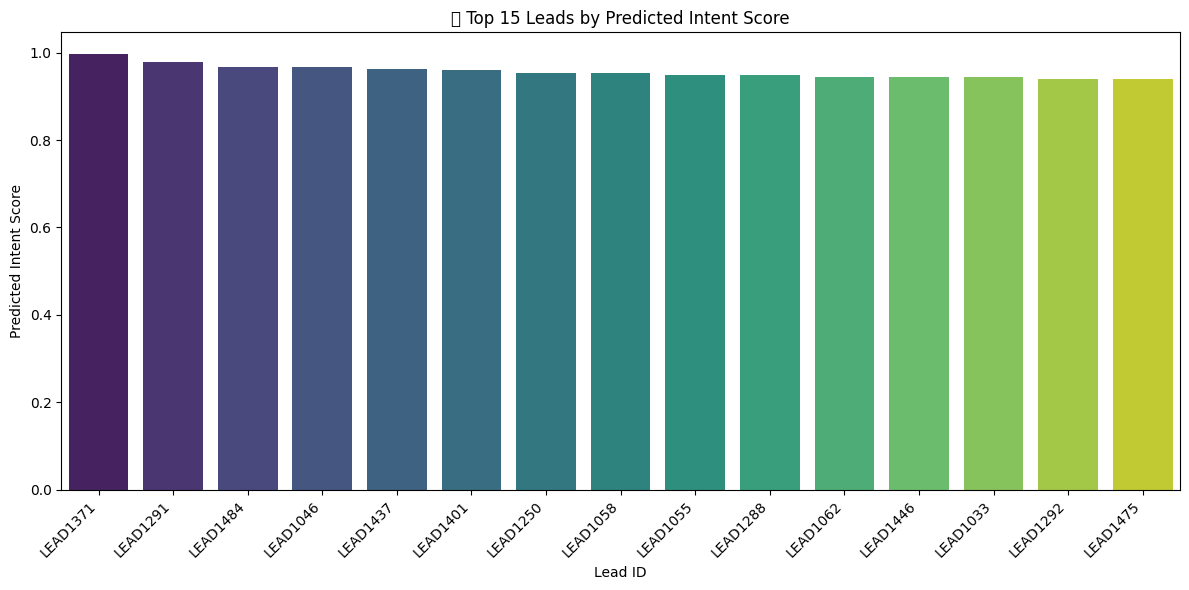

C:\Users\admin\AppData\Local\Temp\ipykernel_15088\3373553664.py:30: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


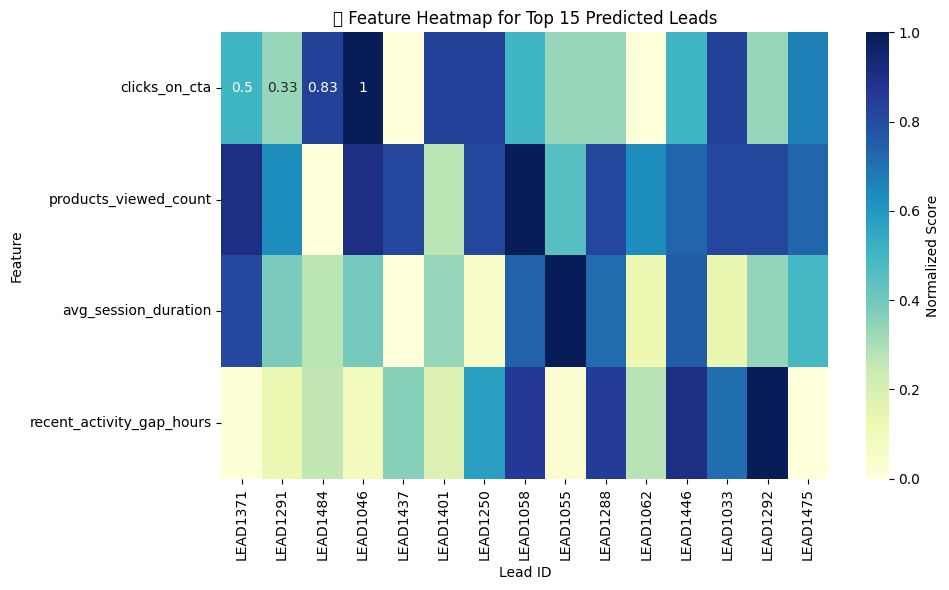

In [21]:
# Recalculate predicted scores for the full dataset
full_pred = model.predict(X)
df['predicted_intent'] = full_pred

# Merge predictions with lead_id
df_viz = df[['lead_id', 'predicted_intent', 'clicks_on_cta', 'products_viewed_count', 'avg_session_duration', 'recent_activity_gap_hours']]

# Sort and pick top 15
top_leads = df_viz.sort_values(by='predicted_intent', ascending=False).head(15)

# Bar Plot of Predicted Intent
plt.figure(figsize=(12, 6))
sns.barplot(data=top_leads, x='lead_id', y='predicted_intent', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("🔝 Top 15 Leads by Predicted Intent Score")
plt.ylabel("Predicted Intent Score")
plt.xlabel("Lead ID")
plt.tight_layout()
plt.show()

# Normalize values for better heatmap comparison
top_heatmap = top_leads.set_index('lead_id')[['clicks_on_cta', 'products_viewed_count', 'avg_session_duration', 'recent_activity_gap_hours']]
top_heatmap_normalized = (top_heatmap - top_heatmap.min()) / (top_heatmap.max() - top_heatmap.min())

plt.figure(figsize=(10, 6))
sns.heatmap(top_heatmap_normalized.T, cmap='YlGnBu', annot=True, cbar_kws={'label': 'Normalized Score'})
plt.title("🧠 Feature Heatmap for Top 15 Predicted Leads")
plt.xlabel("Lead ID")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

4. Improving lift & Adoption

(i) Two Ways to Boost Model Lift
Feature Engineering Improvements
Hyperparameter Tuning

In [28]:
# Step 4.i.1: Feature Engineering Boost (create new interaction features)
df['cta_per_product'] = df['clicks_on_cta'] / df['products_viewed_count']
df['activity_ratio'] = df['avg_session_duration'] / (df['recent_activity_gap_hours'] + 1)

# Re-select features
feature_cols = [
    'clicks_on_cta', 'recent_activity_gap_hours', 'products_viewed_count',
    'last_message_sentiment', 'days_since_first_contact',
    'cta_per_product', 'activity_ratio'
]
X = df[feature_cols]
y = df['intent_score']

# Step 4.i.2: Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}

grid = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=3, scoring='r2')
grid.fit(X, y)

print(f"✅ Best R² Score: {grid.best_score_:.3f}")
print(f"✅ Best Params: {grid.best_params_}")

# Refit with best model
best_model = grid.best_estimator_
df['predicted_intent'] = best_model.predict(X)

✅ Best R² Score: 0.975
✅ Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


(ii) Sales team adoption aids

In [29]:
# Sales-readable report
sales_cols = ['lead_id', 'email_masked', 'phone_masked', 'predicted_intent', 'clicks_on_cta', 'products_viewed_count']
sales_report = df[sales_cols].sort_values(by='predicted_intent', ascending=False).head(10)

# Export or display
print("📄 Top Recommended Leads (For Sales Team):")
print(sales_report.to_string(index=False))

# Optional: save to CSV
sales_report.to_csv("top_leads_for_sales.csv", index=False)


📄 Top Recommended Leads (For Sales Team):
 lead_id     email_masked phone_masked  predicted_intent  clicks_on_cta  products_viewed_count
LEAD1371 l***@example.com   *******698          0.992537              3                     13
LEAD1033 l***@example.com   *******458          0.976204              5                     12
LEAD1401 l***@example.com   *******192          0.973681              5                      6
LEAD1291 l***@example.com   *******004          0.969399              2                     10
LEAD1046 l***@example.com   *******856          0.964790              6                     13
LEAD1484 l***@example.com   *******517          0.963867              5                      3
LEAD1437 l***@example.com   *******600          0.963449              0                     12
LEAD1250 l***@example.com   *******492          0.958881              5                     12
LEAD1055 l***@example.com   *******157          0.950744              2                      8
LEAD1058

5. Real-time Architecture & Scale

In [33]:
import pandas as pd
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Sample dataset
df_path = r'E:\Oops\synthetic_lead_data.csv'
df = pd.read_csv(df_path)

# Features and target
# Drop columns that are identifiers or PII
X = df.drop(columns=["lead_id", "email", "phone_number", "intent_score"], errors='ignore')
y = df["intent_score"]


# Categorical columns
cat_cols = ['user_age_group', 'location_tier', 'occupation_type', 'ad_click_origin']
num_cols = [col for col in X.columns if col not in cat_cols]

# Pipeline
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

model = Pipeline([
    ("prep", preprocessor),
    ("reg", GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42))
])

# Train
model.fit(X, y)

# Save model
joblib.dump(model, "gb_model.pkl")


['gb_model.pkl']

In [36]:
from sklearn.preprocessing import OneHotEncoder
import pickle

# Select categorical columns
categorical_cols = ['user_age_group', 'location_tier', 'occupation_type', 'ad_click_origin']

# Fit encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_cols])

# Save encoder to file
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

print("✅ Encoder saved as encoder.pkl")


✅ Encoder saved as encoder.pkl


In [37]:
# Load trained model and encoder
model = joblib.load("gb_model.pkl")
encoder = joblib.load("encoder.pkl")  # if used one-hot encoding

app = FastAPI()

class LeadData(BaseModel):
    avg_session_duration: float
    clicks_on_cta: int
    recent_activity_gap_hours: float
    user_age_group: str
    location_tier: str
    occupation_type: str
    ad_click_origin: str
    products_viewed_count: int
    last_message_sentiment: float
    days_since_first_contact: int

def push_to_crm_or_whatsapp(lead_id: str, score: float):
    # Simulate a CRM/WhatsApp push (placeholder)
    print(f"📨 Sent to CRM for {lead_id} with score {score:.2f}")

@app.post("/predict")
def predict_lead_score(data: LeadData, background_tasks: BackgroundTasks):
    # Convert input to DataFrame
    input_df = pd.DataFrame([data.dict()])

    # Encode categorical columns (should match training)
    input_encoded = encoder.transform(input_df)

    # Predict intent score
    score = model.predict(input_encoded)[0]

    # Simulate lead_id for now
    lead_id = f"LEAD{np.random.randint(10000,99999)}"

    # Async push to CRM or WhatsApp
    background_tasks.add_task(push_to_crm_or_whatsapp, lead_id, score)

    return {"lead_id": lead_id, "predicted_intent_score": round(score, 3)}